In [2]:
import warnings
warnings.filterwarnings("ignore", "Wswiglal-redir-stdio")

import matplotlib.pyplot as plt
import numpy as np

import momenta.utils.flux as flux
from momenta.io import GW, NuDetector, SuperNuDetector, Parameters
from momenta.io.neutrinos import BackgroundFixed, BackgroundPoisson
from momenta.io.neutrinos_irfs import EffectiveAreaAllSky
from momenta.stats.run import run_ultranest
from momenta.stats.constraints import get_limits

# Starting remarks
* For the notebook to run, you need to install `momenta` as a package (`pip install -e .` from the root directory).
* It is better to keep this code at its current location as there are some relative paths defined here, though you may modify it.

# Setup

## General parameters

In [3]:
parameters = Parameters("input_files/config.yaml")
parameters.set_models(flux=flux.FluxFixedPowerLaw(1, 1e6, 2, eref=1))

## GW-side definitions

In [4]:
gw = GW(
    name="GW190412",
    path_to_fits="input_files/gw_catalogs/GW190412/GW190412_PublicationSamples.fits",
    path_to_samples="input_files/gw_catalogs/GW190412/GW190412_subset.h5",
)
gw.set_parameters(parameters)

[2024-10-29 16:47:58,168:momenta:INFO] [GW] Fits is loaded from the file GW190412_PublicationSamples.fits
[2024-10-29 16:47:58,169:momenta:INFO] [GW] Samples are loaded from the file GW190412_subset.h5


## Neutrino-side definitions

### Detector definitions

We use input file to define Super-Kamiokande detector but we can also use directly a dictionary to build a new detector (here with only one sample)

In [5]:
det1 = NuDetector(
    {
        "name": "Detector1",
        "samples": ["SampleA"],
    }
)
det2 = NuDetector(
    {
        "name": "Detector2",
        "samples": ["SampleB"],
    }
)

[2024-10-29 16:47:58,209:momenta:INFO] [NuDetector] Object is loaded from a dictionary object.
[2024-10-29 16:47:58,210:momenta:INFO] [NuDetector] Object is loaded from a dictionary object.


### Effective area inputs

The detector response of any neutrino sample is especially characterized by their effective area. The effective area is the function that, when convoluted with the neutrino spectrum, gives the expected number of signal events:
\begin{equation*}
N_{\rm sig}(\Omega) = \int_{E_{\min}}^{E_{\max}} A_{\rm eff}(E, \Omega) \times \frac{dN}{dE} dE
\end{equation*}
where the effective area $A_{\rm eff}(E, \Omega)$ is expressed in ${\rm cm}^2$.

In [6]:
# Custom effective area that is constant over the full sky and just depends on energy
class EffAreaDet1(EffectiveAreaAllSky):
    def evaluate(self, energy, ipix, nside):
        return (energy / 100) ** 2 * np.exp(-energy / 3000)


class EffAreaDet2(EffectiveAreaAllSky):
    def evaluate(self, energy, ipix, nside):
        return (energy / 100) ** 3 * np.exp(-energy / 30000)


det1.set_effective_areas([EffAreaDet1()])
det2.set_effective_areas([EffAreaDet2()])

### Observation inputs

The other main ingredients on the neutrino side are the observed and expected number of events in the different samples. The observed number of events is just an integer. The expected one may be provided in different formats that are presented below.

In [7]:
bkg1 = [BackgroundPoisson(10, 20)]
nobs1 = [0]

bkg2 = [BackgroundFixed(0.5)]
nobs2 = [0]

# Filling values to the detector objects
det1.set_observations(nobs1, bkg1)
det2.set_observations(nobs2, bkg2)

# Computing the limits per detector

### Compute limits on the flux for E^-2 spectrum

In [8]:
parameters.flux = flux.FluxFixedPowerLaw(0.1, 1e6, 2, eref=1)
#
model, result = run_ultranest(det1, gw, parameters)
limit1 = get_limits(result["samples"], model)["flux0_norm"]
print(f"Limit on E^2 dN/dE for Detector1 = {limit1} GeV/cm²")
#
model, result = run_ultranest(det2, gw, parameters)
limit2 = get_limits(result["samples"], model)["flux0_norm"]
print(f"Limit on E^2 dN/dE for Detector2 = {limit2} GeV/cm²")

Limit on E^2 dN/dE for Detector1 = 46.16876198898185 GeV/cm²
Limit on E^2 dN/dE for Detector2 = 0.015466734961854375 GeV/cm²


# Computing the limits combining detectors

In [9]:
# define combined detector
combined_det = SuperNuDetector("Detector1 + Detector2")
combined_det.add_detector(det1)
combined_det.add_detector(det2)

# get upper limit on flux
gammas = np.linspace(1, 4, 31)
limits1, limits2, limitsc = [], [], []
for gamma in gammas:
    parameters.flux = flux.FluxFixedPowerLaw(0.1, 1e6, gamma)
    model, result = run_ultranest(det1, gw, parameters)
    limits1.append(get_limits(result["samples"], model)["flux0_norm"])
    model, result = run_ultranest(det2, gw, parameters)
    limits2.append(get_limits(result["samples"], model)["flux0_norm"])
    model, result = run_ultranest(combined_det, gw, parameters)
    limitsc.append(get_limits(result["samples"], model)["flux0_norm"])

[2024-10-29 16:48:15,527:momenta:INFO] [SuperDetector] Detector Detector1 is added to the SuperDetector.
[2024-10-29 16:48:15,528:momenta:INFO] [SuperDetector] Detector Detector2 is added to the SuperDetector.


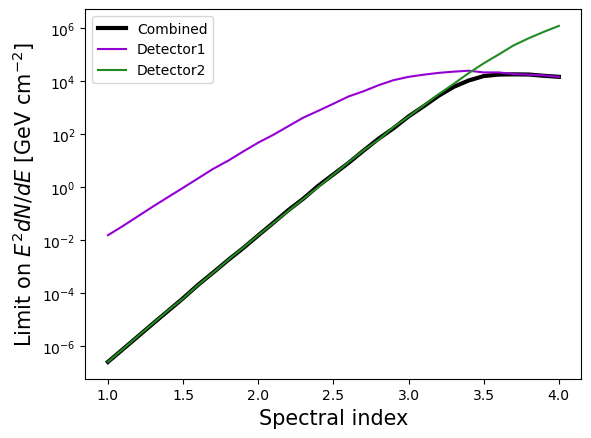

In [10]:
plt.plot(gammas, limitsc, color="black", lw=3, label="Combined")
plt.plot(gammas, limits1, color="darkviolet", lw=1.5, label="Detector1")
plt.plot(gammas, limits2, color="forestgreen", lw=1.5, label="Detector2")
plt.xlabel(r"Spectral index", fontsize=15)
plt.ylabel(r"Limit on $E^2 dN/dE$ [GeV cm$^{-2}$]", fontsize=15)
plt.yscale("log")
plt.legend(loc="best")